# **Lab 7.2 CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import zipfile
from collections import Counter

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [2]:
# Step 1: Extract the ZIP file
zip_file_path = 'lab7_2_thai-handwriting-number.zip'  
extract_path = 'Lab7_2_Thai-Handwriting-Number_Dataset'

# Check if the extraction folder already exists
if not os.path.exists(extract_path):
    # Create the extraction folder
    os.makedirs(extract_path)
    
    # Step 2: Extract the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print(f'The folder {extract_path} already exists. Skipping extraction.')

The folder Lab7_2_Thai-Handwriting-Number_Dataset already exists. Skipping extraction.


In [3]:
def get_dataset(path):
    """Retrieves class names and their corresponding indices from the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
    
    Returns:
        dataset_classes: List of class names.
        class_names: List of corresponding indices for the classes.
    """
    dataset = ImageFolder(root=path)
    return dataset

def get_dataset_classes(dataset):
    """Retrieves class names and their corresponding indices from the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
    
    Returns:
        dataset_classes: List of class names.
        class_names: List of corresponding indices for the classes.
    """
    dataset_classes = dataset.classes  # e.g., ['battleship', 'patrol boat', 'submarine']
    class_names = list(range(len(dataset_classes)))
    return dataset_classes, class_names

def print_dataset_info(dataset_path, dataset, batch=None, labels=None):
    """Prints information about the dataset.

    Args:
        dataset: The dataset object (e.g., from ImageFolder or CustomImageDataset).
        dataset_path: The path to the dataset directory.
        batch: A batch of images (optional).
        labels: Corresponding labels for the batch (optional).
    """
    # Print class names and their corresponding indices
    
    dataset_classes, class_names = get_dataset_classes(dataset)
    print('class_names: dataset.classes')
    print(dataset_classes)

    for class_name, class_index in zip(dataset_classes, class_names):
        print(f"{class_index}: {class_name}")

    print('-' * 100)
    
    # Print batch shape and labels shape if provided
    if batch is not None and labels is not None:
        print(f'Batch Shape: {batch.shape}, Labels Shape: {labels.shape}')
    else:
        print('Batch and labels shapes are not provided.')

    print('-' * 100)

    # Print dataset information
    print(f"📃 {os.path.basename(dataset_path).capitalize()} Dataset:")
    
    # Check if the dataset has an attribute for samples
    if hasattr(dataset, 'samples'):
        # Count number of images in each class for ImageFolder
        class_counts = Counter(label for _, label in dataset.samples)
    else:
        # Count number of images in each class for CustomImageDataset
        class_counts = Counter(os.path.basename(os.path.dirname(img_path)) for img_path in dataset.image_files)

    # Print the count for each class
    for class_index, count in class_counts.items():
        if isinstance(class_index, int) and hasattr(dataset, 'classes'):
            class_name = dataset.classes[class_index]
        else:
            class_name = class_index  # If it's already a class name

        print(f"\tNumber of images in class {class_name}: {count}")

    # Total number of samples
    total_samples = len(dataset)
    print(f"\tNumber of samples: {total_samples}")

def imshow_grid(batch, labels, class_names):
    """Display a grid of images with their labels.

    Args:
        batch: A batch of images (Tensor).
        labels: Corresponding labels for the images (Tensor).
        class_names: List of class names for the labels.
    """
    plt.figure(figsize=(10, 10))
    for i in range(16):  # Display the first 16 images
        plt.subplot(4, 4, i + 1)  # Create a 4x4 grid
        img = batch[i].numpy().transpose((1, 2, 0))  # Convert to HWC format
        img = np.clip(img, 0, 1)  # Ensure pixel values are between 0 and 1
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [4]:
def load_data(path, class_names):
    ### START CODE HERE ###
    # Define the transformations
    transform = transforms.Compose([
      transforms.Grayscale(),  # Convert to grayscale
      transforms.Resize((28, 28)),  # Resize to 28x28
      transforms.ToTensor(),  # Convert to tensor
      transforms.Pad(padding=10,  fill=255),  # Pad with 10 pixels on all sides
      transforms.RandomRotation(degrees=45),  # Randomly rotate by up to 45 degrees
      transforms.CenterCrop(size=(28, 28))  # Crop center 28x28
  ])

    # Load the dataset using ImageFolder
    dataset = ImageFolder(root=path, transform=transform)

    # Create DataLoaders for train and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


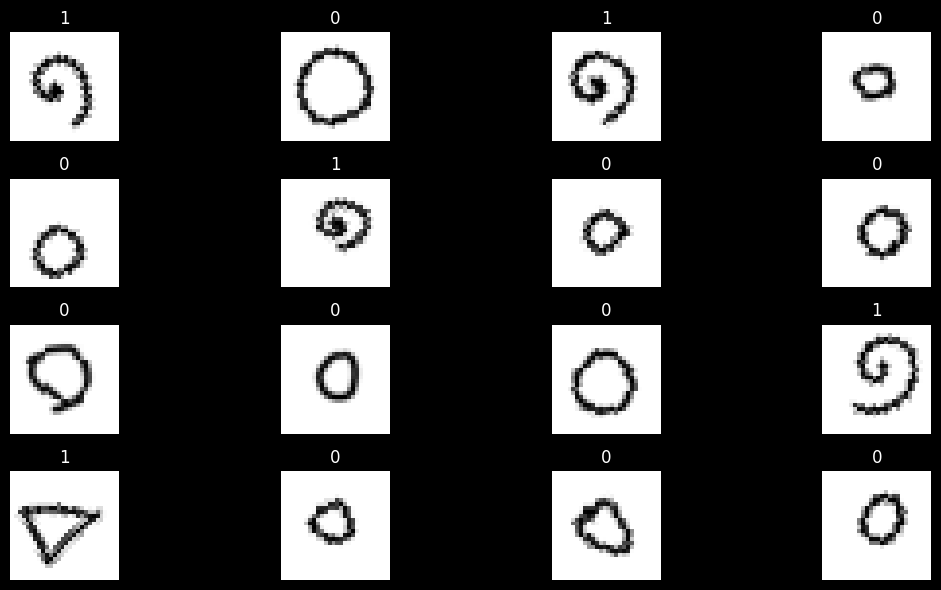

</details>

class_names: dataset.classes
['๐', '๑', '๒', '๓', '๔', '๕', '๖', '๗', '๘', '๙']
0: ๐
1: ๑
2: ๒
3: ๓
4: ๔
5: ๕
6: ๖
7: ๗
8: ๘
9: ๙
----------------------------------------------------------------------------------------------------
Batch Shape: torch.Size([32, 1, 28, 28]), Labels Shape: torch.Size([32])
----------------------------------------------------------------------------------------------------
📃 Thai-handwriting-number.appspot.com Dataset:
	Number of images in class ๐: 388
	Number of images in class ๑: 389
	Number of images in class ๒: 389
	Number of images in class ๓: 388
	Number of images in class ๔: 388
	Number of images in class ๕: 388
	Number of images in class ๖: 388
	Number of images in class ๗: 388
	Number of images in class ๘: 388
	Number of images in class ๙: 388
	Number of samples: 3882


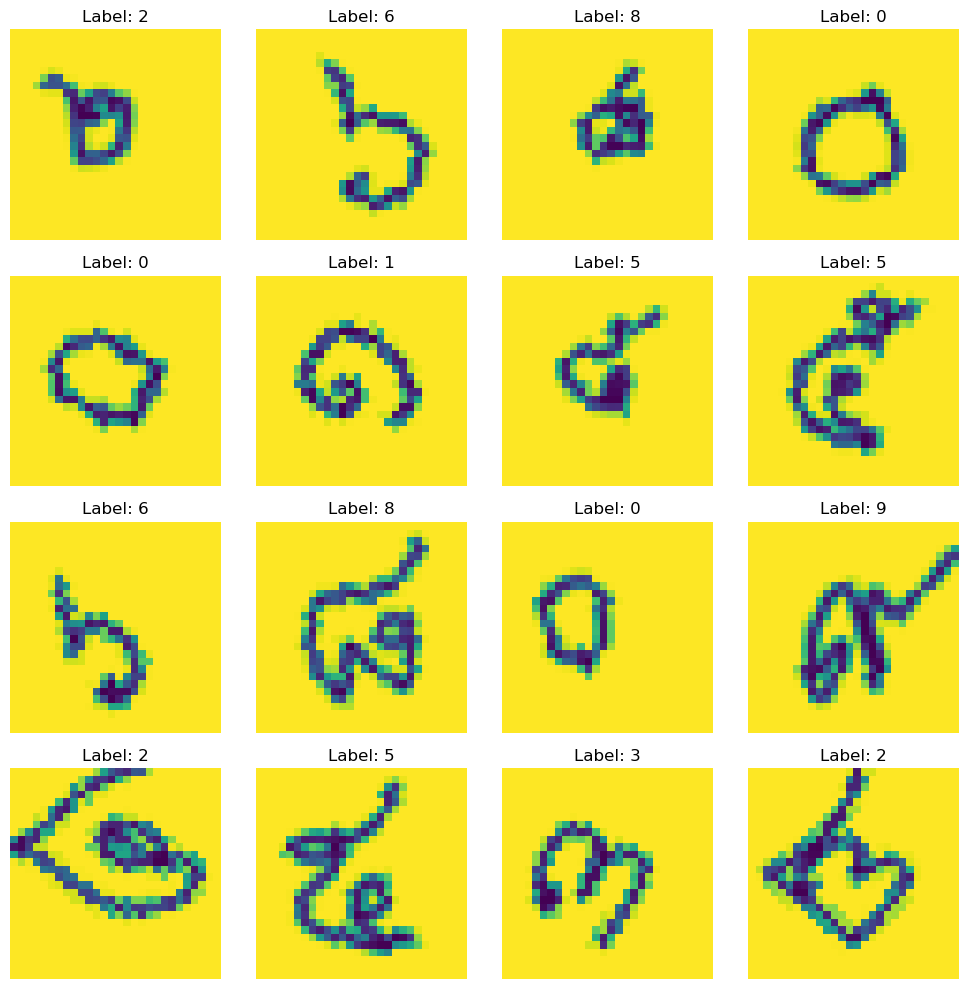

In [5]:
### START CODE HERE ###
dataset_path = 'Lab7_2_Thai-Handwriting-Number_Dataset/thai-handwriting-number.appspot.com'
dataset = get_dataset(dataset_path)

dataset_classes = dataset.classes  # e.g., ['o', '๑', '๒']
class_names = list(range(len(dataset_classes))) # e.g., [0, 1, 2]

train_loader, test_loader = load_data(dataset_path,class_names)

# Get a batch of images
data_iter = iter(train_loader)
batch, labels = next(data_iter)

print_dataset_info(dataset_path, dataset, batch, labels)

imshow_grid(batch, labels, class_names)


### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [33]:
### START CODE HERE ###
# class CustomLeNet(nn.Module):
#     def __init__(self):
#         super(CustomLeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Output: (batch, 6, 24, 24)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Output: (batch, 16, 8, 8)
#         self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Update to match the output size
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = nn.functional.relu(self.conv1(x))
#         x = nn.functional.max_pool2d(x, 2)
#         x = nn.functional.relu(self.conv2(x))
#         x = nn.functional.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 4 * 4)  # Update to match the output size
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Initialize the feature maps and layer names list
        self.feature_maps = []
        self.layer_names = []

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("conv1 + ReLU")
        
        x = nn.functional.max_pool2d(x, 2)
        self.feature_maps.append(x.detach())
        self.layer_names.append("max pool 1")

        x = nn.functional.relu(self.conv2(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("conv2 + ReLU")
        
        x = nn.functional.max_pool2d(x, 2)
        self.feature_maps.append(x.detach())
        self.layer_names.append("max pool 2")

        x = x.view(-1, 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc1 + ReLU")
        
        x = nn.functional.relu(self.fc2(x))
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc2 + ReLU")
        
        x = self.fc3(x)
        self.feature_maps.append(x.detach())
        self.layer_names.append("fc3(output)")
        return x

### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [7]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import torch.optim as optim

In [14]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    ### START CODE HERE ###
    print("🤖Training on", device)
    model = model.to(device)

    # Initialize lists to store predictions and labels
    all_preds = []
    all_labels = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()
            total_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())
        
        avg_train_loss = total_train_loss / len(train_loader)

        # Testing phase
        model.eval()
        total_test_loss = 0
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')

        with torch.no_grad():
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, gt)
                total_test_loss += loss.item()
                
                # Store predictions and ground truth for confusion matrix
                all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                all_labels.extend(gt.cpu().numpy())
                
                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        print(f'Summary for Epoch {epoch+1}/{epochs}:')
        print(f'    Train    avg_loss: {avg_train_loss}')
        print(f'    Test     avg_loss: {avg_test_loss}')

        # Save model at the last epoch
        if epoch == epochs - 1 and checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model saved at {checkpoint_path}')

    return all_preds, all_labels  # Return predictions and labels

    ### END CODE HERE ###


Use your `train()` function to train models.

In [15]:
### START CODE HERE ###
# # Initialize model, optimizer, and loss function
model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
all_preds, all_labels = train(model, opt, loss_fn, train_loader, test_loader, epochs=1, 
                            checkpoint_path='CustomLeNet.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

🤖Training on cpu


📄Testing: 100%|██████████| 25/25 [00:10<00:00,  2.38batch/s, loss=2.26]

Summary for Epoch 1/1:
    Train    avg_loss: 2.330722813703576
    Test     avg_loss: 2.3049880504608153
Model saved at CustomLeNet.pth


Try to load the weights into the model and the confusion matrix.

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

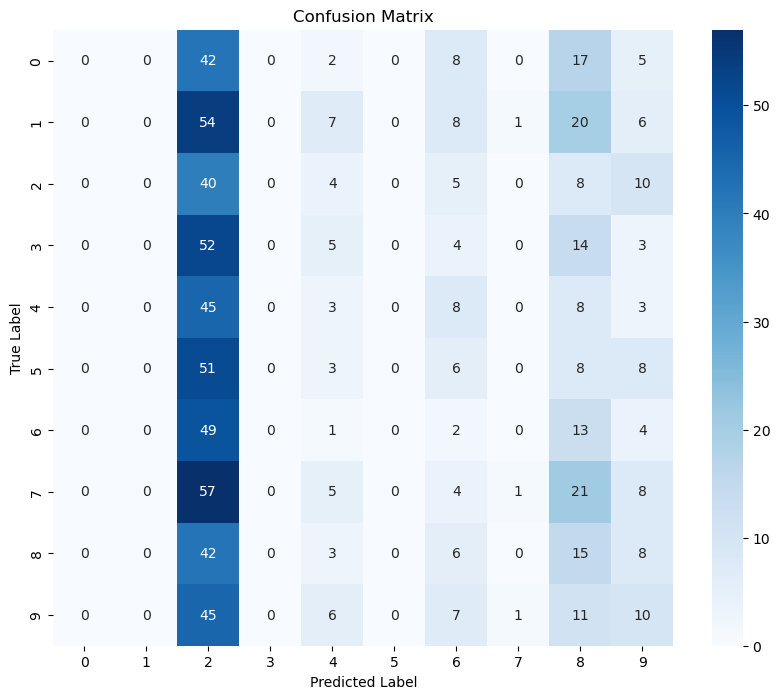

In [17]:
### START CODE HERE ###
# Load the model weights
model.load_state_dict(torch.load('CustomLeNet.pth'))
model.eval()  # Set the model to evaluation mode

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [49]:
def visualize_feature_maps(model, input_image, layers=None, output_folder='feature_maps'):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    model.eval()  # Set model to evaluation mode
    
    # Clear previous feature maps and layer names
    model.feature_maps.clear()
    model.layer_names.clear()
    
    with torch.no_grad():
        _ = model(input_image)  # Forward pass to capture feature maps

    # If no specific layers are provided, visualize all layers
    if layers is None:
        layers = range(len(model.feature_maps))

    # Visualize and save selected feature maps
    for i in layers:
        if i < len(model.feature_maps):
            feature_map = model.feature_maps[i]
            if feature_map.dim() == 4:  # For convolutional layers
                num_feature_maps = feature_map.shape[1]
                fig, axes = plt.subplots(1, num_feature_maps, figsize=(num_feature_maps * 2, 2))
                fig.suptitle(f'Feature Maps from {model.layer_names[i]}', fontsize=16)

                for j in range(num_feature_maps):
                    axes[j].imshow(feature_map[0, j].cpu(), cmap='gray')
                    axes[j].axis('off')

                plt.show()  # Show the plot in the notebook or interactive window
                plt.savefig(os.path.join(output_folder, f'feature_map_layer_{i + 1}.png'))
                plt.close(fig)
            elif feature_map.dim() == 2:  # For fully connected layers
                plt.figure(figsize=(10, 1))
                plt.title(f'Output from {model.layer_names[i]}')
                plt.imshow(feature_map.cpu().numpy().flatten()[None, :], aspect='auto', cmap='gray')
                plt.axis('off')
                plt.show()  # Show the plot in the notebook or interactive window
                plt.savefig(os.path.join(output_folder, f'feature_map_layer_{i + 1}.png'))
                plt.close()

Captured Feature Maps:
Layer 1 (conv1 + ReLU)	:	torch.Size([32, 6, 24, 24])
Layer 2 (max pool 1)	:	torch.Size([32, 6, 12, 12])
Layer 3 (conv2 + ReLU)	:	torch.Size([32, 16, 8, 8])
Layer 4 (max pool 2)	:	torch.Size([32, 16, 4, 4])
Layer 5 (fc1 + ReLU)	:	torch.Size([32, 120])
Layer 6 (fc2 + ReLU)	:	torch.Size([32, 84])
Layer 7 (fc3(output))	:	torch.Size([32, 10])


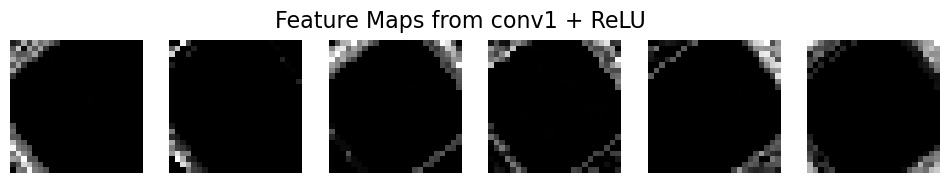

<Figure size 640x480 with 0 Axes>

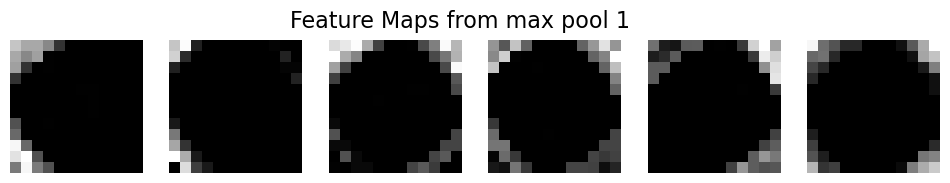

<Figure size 640x480 with 0 Axes>

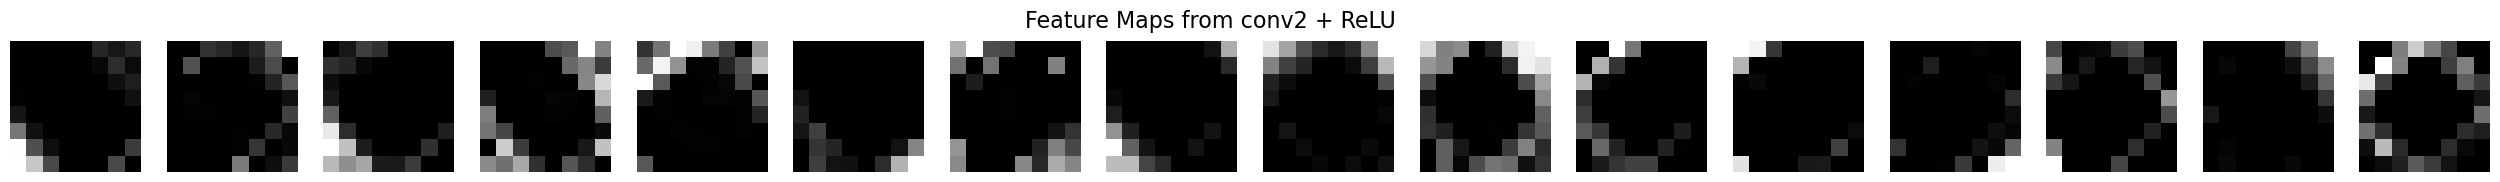

<Figure size 640x480 with 0 Axes>

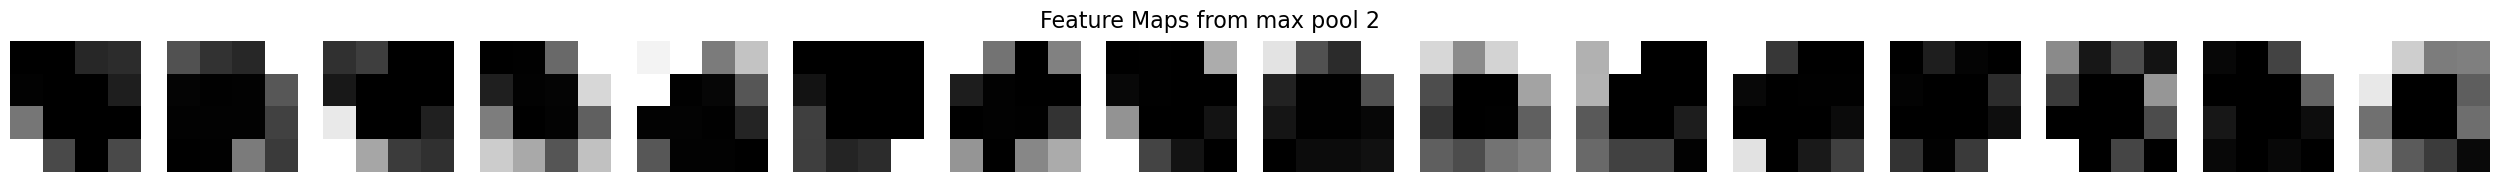

<Figure size 640x480 with 0 Axes>

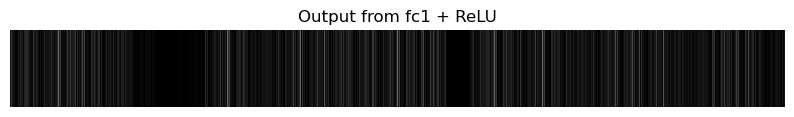

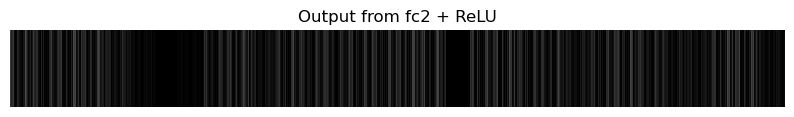

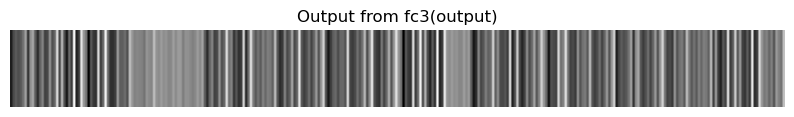

In [50]:
### START CODE HERE ###
# Load a batch of images from the train_loader
data_iter = iter(train_loader)
images, _ = next(data_iter)


# Create model instance
model = CustomLeNet()

# Forward pass to print feature maps
_ = model(images)  # This will print shapes of feature maps

# Access and print feature maps
feature_maps = model.feature_maps
print("Captured Feature Maps:")
for i, (name, fmap) in enumerate(zip(model.layer_names, model.feature_maps)):
    print(f"Layer {i + 1} ({name})\t:\t{fmap.shape}")

layers_to_visualize = None
visualize_feature_maps(model, images, layers=layers_to_visualize, output_folder='feature_maps')
### END CODE HERE ###

---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.
